In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the images

In [8]:
def compute_fourier(img):
    fft = np.fft.fft2(img)
    amplitude = np.abs(fft)
    phase = np.angle(fft)
    return amplitude, phase

# Apply Fourier Transform to all images
x_train_fft = [compute_fourier(img) for img in x_train]
x_test_fft = [compute_fourier(img) for img in x_test]

In [9]:
def prepare_data(fft_data):
    amplitude = np.array([amp for amp, _ in fft_data])
    phase = np.array([phase for _, phase in fft_data])
    combined = np.stack((amplitude, phase), axis=-1)
    return combined

x_train_combined = prepare_data(x_train_fft)
x_test_combined = prepare_data(x_test_fft)

In [12]:
from tensorflow.keras import layers, models

input_shape = (28, 28, 2)

# Encoder
inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 14x14
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 7x7
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4

# Decoder
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)  # 8x8
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 16x16
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 32x32

# Extra convolution to reduce dimensions from 32x32 to 28x28
x = layers.Conv2D(32, (3, 3), activation='relu', padding='valid')(x)  # 30x30
x = layers.Conv2D(32, (3, 3), activation='relu', padding='valid')(x)  # 28x28
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output 28x28

autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 2)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 128)         0   

In [13]:
autoencoder.fit(x_train_combined, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_combined, x_test))

Epoch 1/50
235/235 [==============================] - 92s 389ms/step - loss: 0.2251 - val_loss: 0.1795
Epoch 2/50
235/235 [==============================] - 93s 395ms/step - loss: 0.1633 - val_loss: 0.1470
Epoch 3/50
235/235 [==============================] - 92s 391ms/step - loss: 0.1418 - val_loss: 0.1362
Epoch 4/50
235/235 [==============================] - 92s 390ms/step - loss: 0.1313 - val_loss: 0.1253
Epoch 5/50
235/235 [==============================] - 94s 401ms/step - loss: 0.1242 - val_loss: 0.1218
Epoch 6/50
235/235 [==============================] - 94s 398ms/step - loss: 0.1192 - val_loss: 0.1191
Epoch 7/50
235/235 [==============================] - 94s 400ms/step - loss: 0.1155 - val_loss: 0.1146
Epoch 8/50
235/235 [==============================] - 94s 399ms/step - loss: 0.1126 - val_loss: 0.1136
Epoch 9/50
235/235 [==============================] - 93s 398ms/step - loss: 0.1101 - val_loss: 0.1113
Epoch 10/50
235/235 [==============================] - 96s 408ms/step - l

In [23]:
#visualizing latent space
encoder = models.Model(inputs, encoded)
latent_space = encoder.predict(x_test_combined)

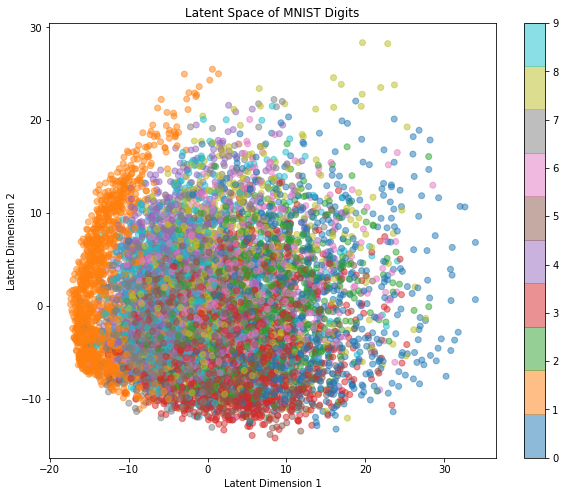

In [32]:
from sklearn.decomposition import PCA
# Flatten latent space if needed (for dimensionality reduction)
latent_space_flat = latent_space.reshape(-1, np.prod(latent_space.shape[1:]))

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_space_flat)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, cmap='tab10', alpha=0.5)
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space of MNIST Digits')
plt.show()

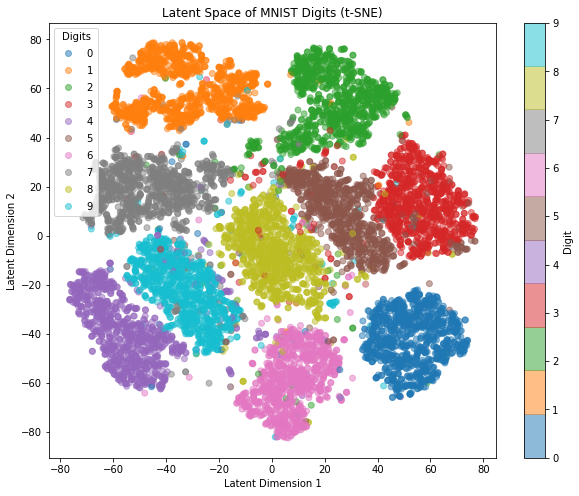

In [140]:
from sklearn.manifold import TSNE
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent_space_flat)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, cmap='tab10', alpha=0.5)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.legend(*scatter.legend_elements(), title="Digits")
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space of MNIST Digits (t-SNE)')
plt.show()

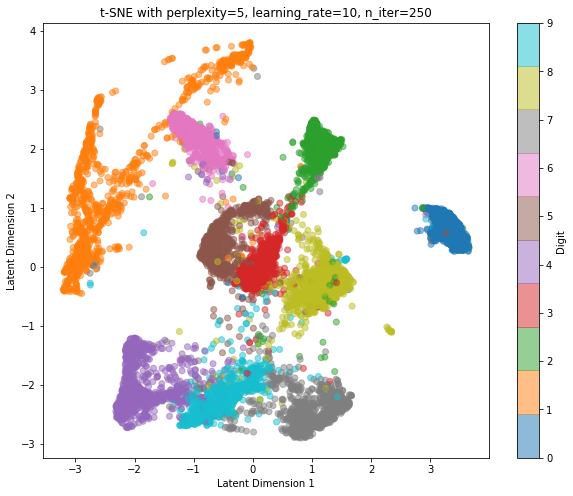

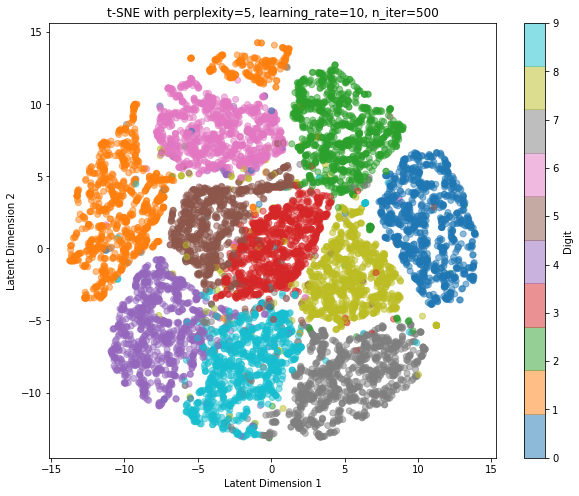

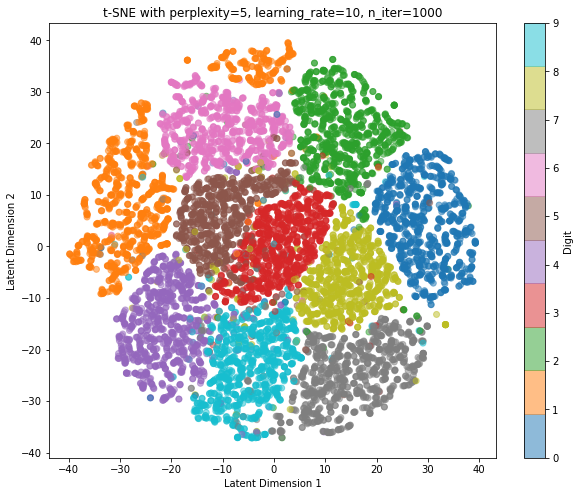

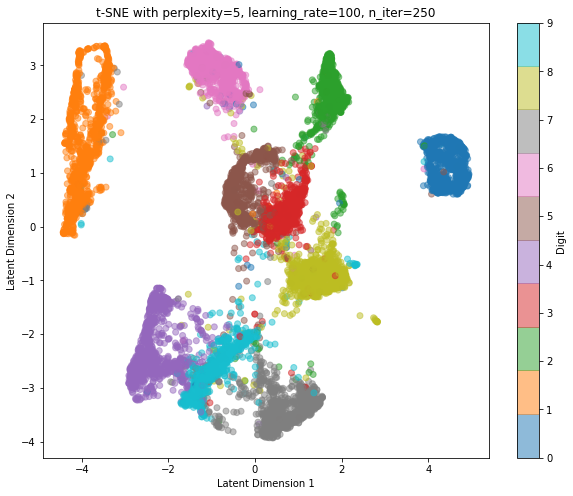

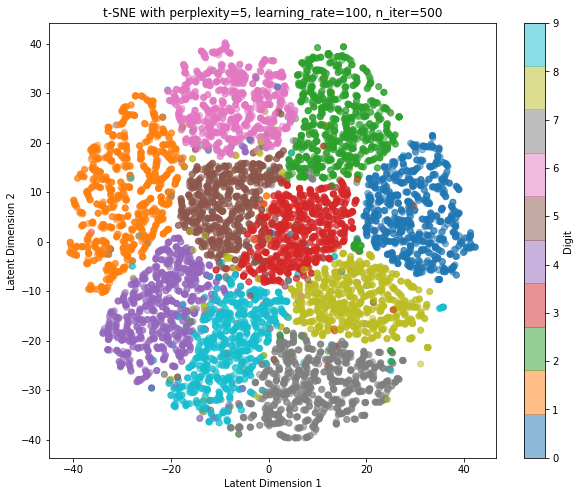

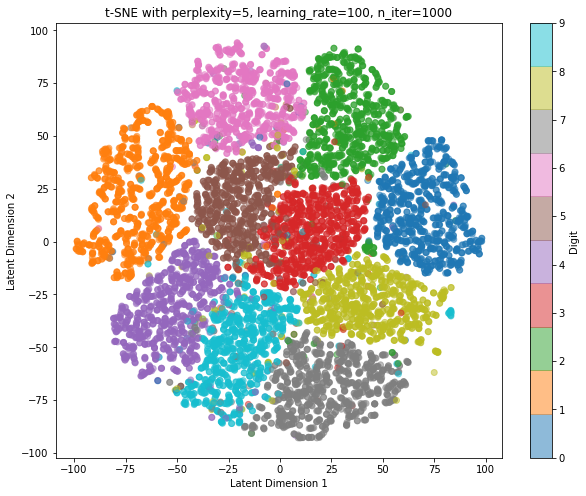

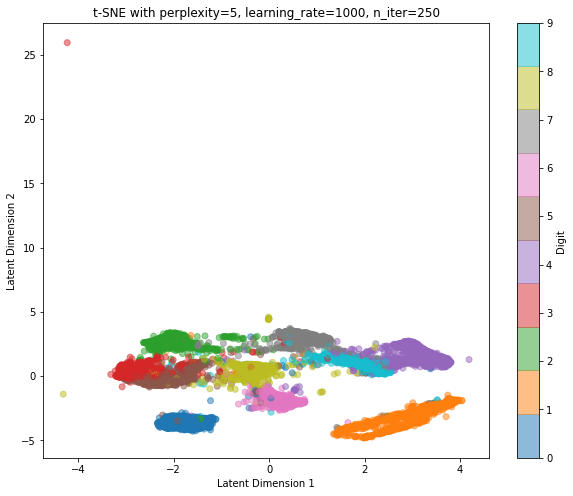

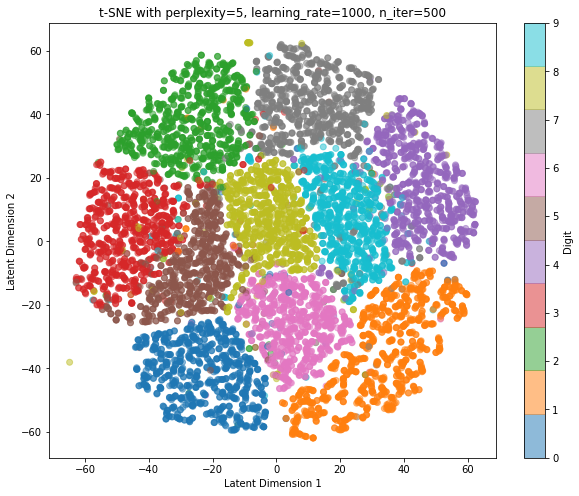

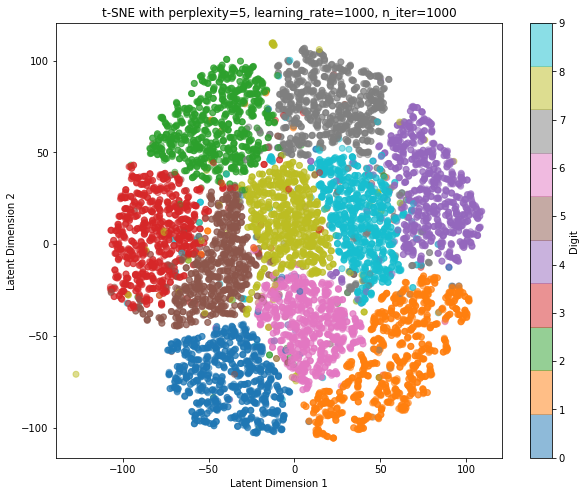

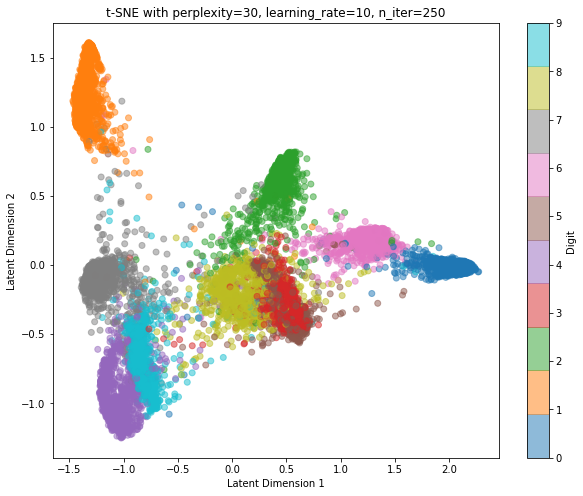

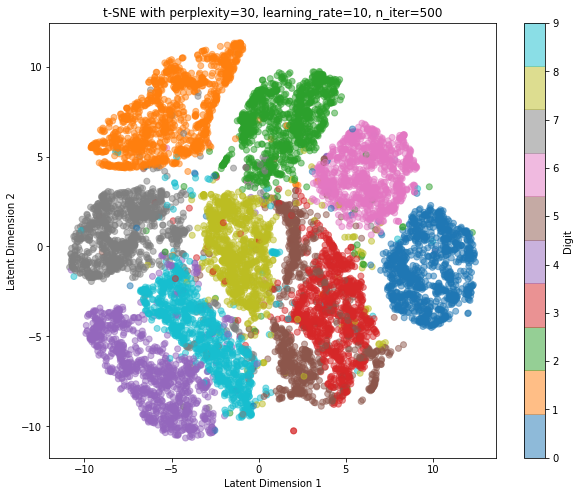

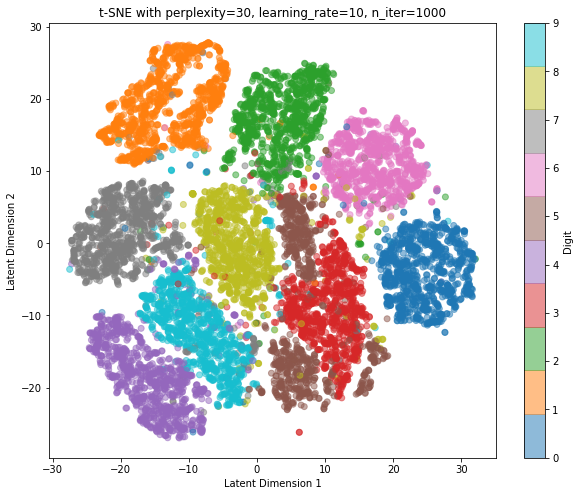

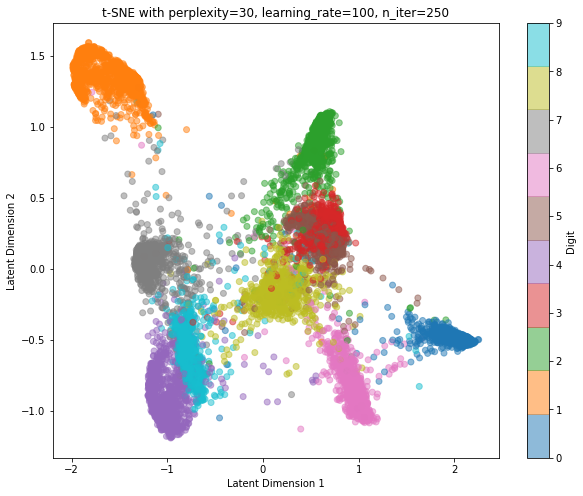

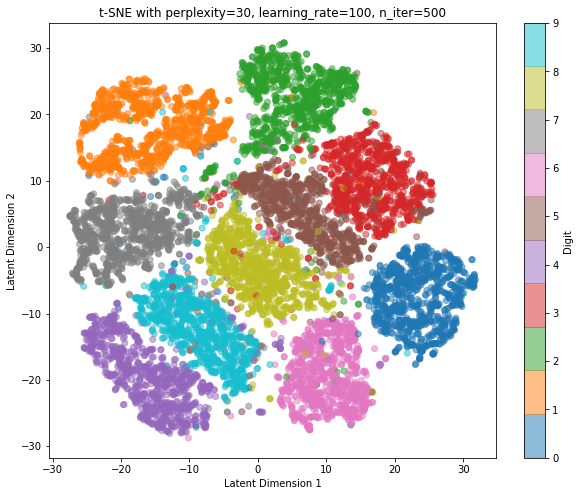

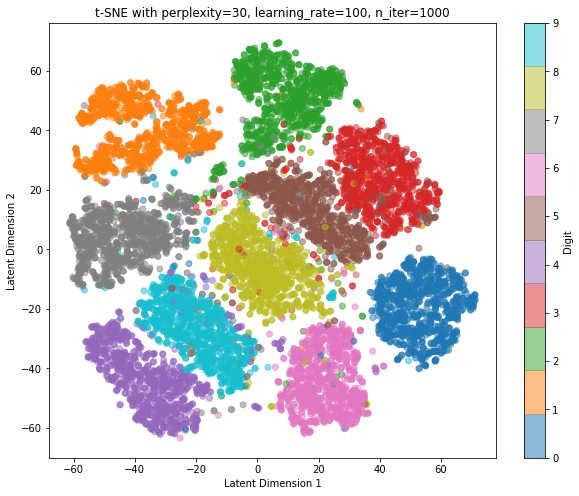

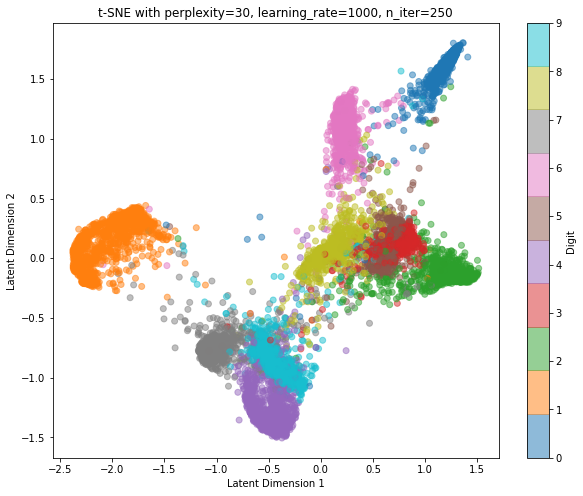

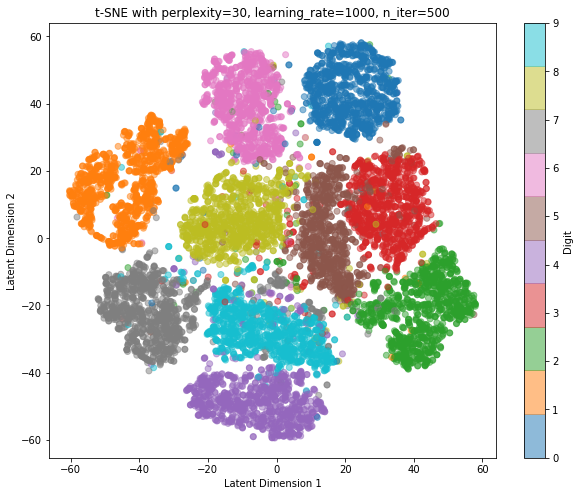

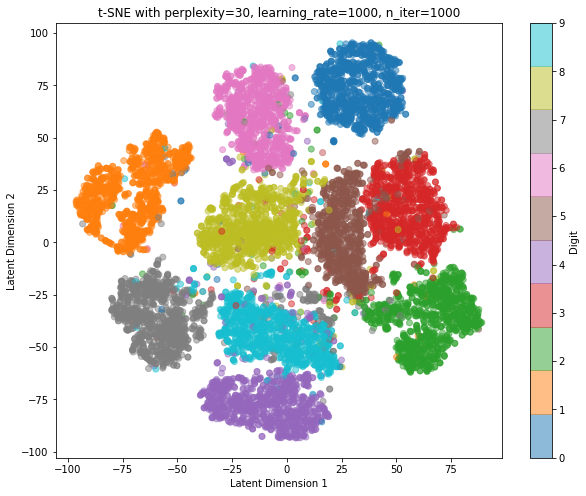

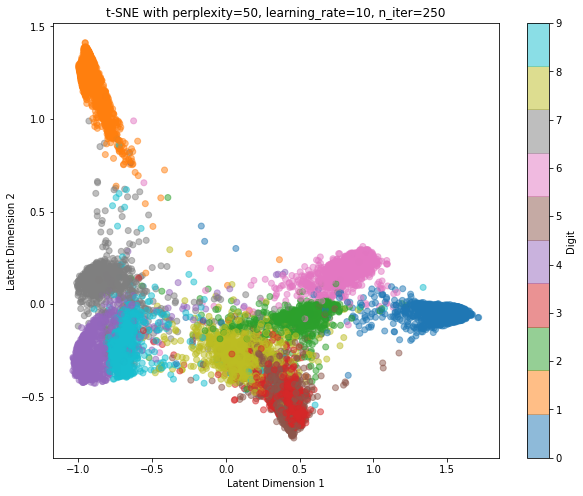

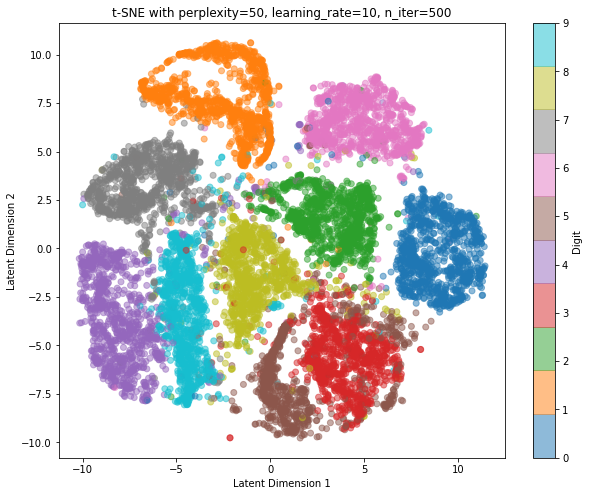

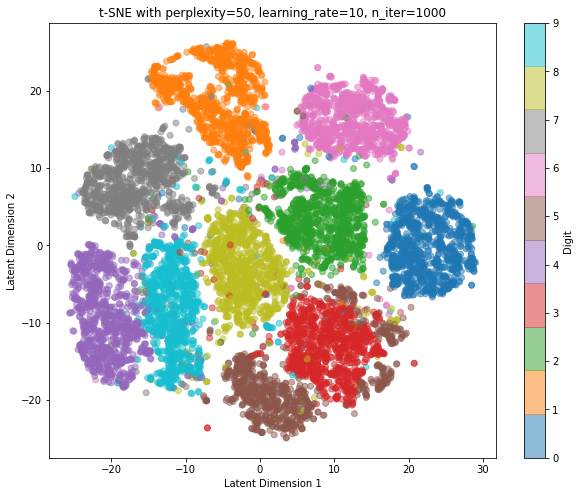

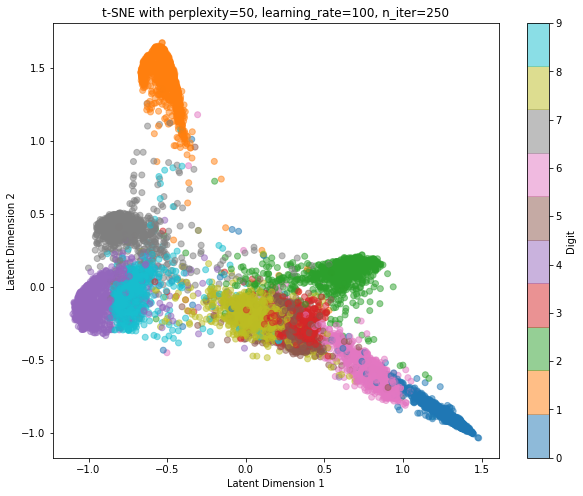

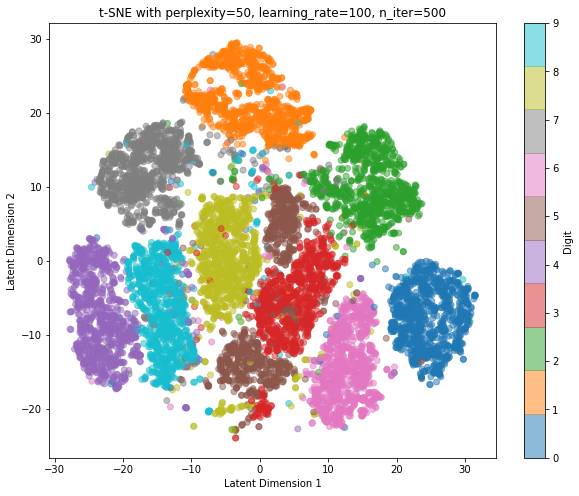

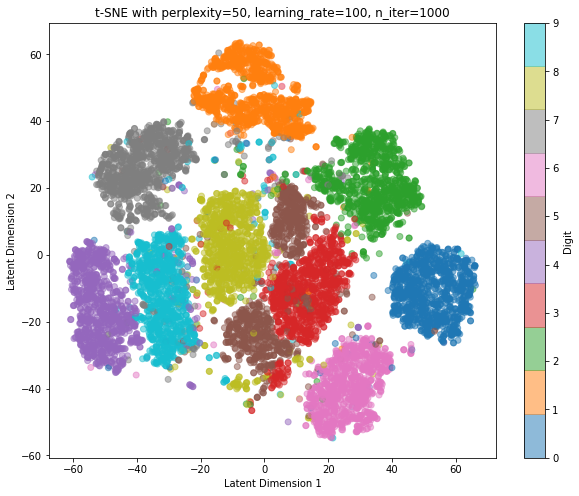

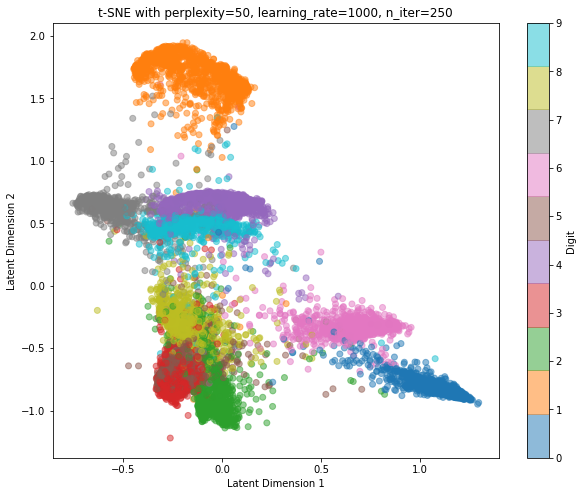

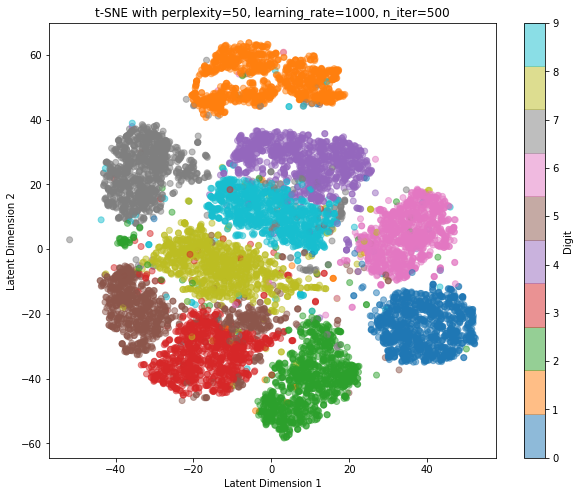

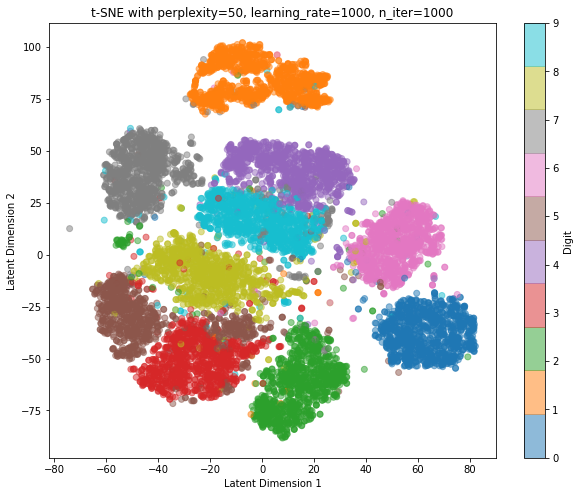

In [35]:
# Experiment with different t-SNE parameters
perplexities = [5, 30, 50]
learning_rates = [10, 100, 1000]
iterations = [250, 500, 1000]

for perplexity in perplexities:
    for learning_rate in learning_rates:
        for n_iter in iterations:
            tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=0)
            latent_2d = tsne.fit_transform(latent_space_flat)

            # Plot the results
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, cmap='tab10', alpha=0.5)
            plt.colorbar(scatter, ticks=range(10), label='Digit')
            plt.xlabel('Latent Dimension 1')
            plt.ylabel('Latent Dimension 2')
            plt.title(f't-SNE with perplexity={perplexity}, learning_rate={learning_rate}, n_iter={n_iter}')
            plt.show()


In [41]:
# Start from the encoded input
encoded_input = tf.keras.Input(shape=encoded.shape[1:])
decoder_layer = autoencoder.layers[-9](encoded_input)  # First layer of the decoder
for layer in autoencoder.layers[-8:]:
    decoder_layer = layer(decoder_layer)
    
decoder = tf.keras.Model(encoded_input, decoder_layer)

# Reconstruct the images from the latent vectors
reconstructed_images = decoder.predict(latent_vectors)


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


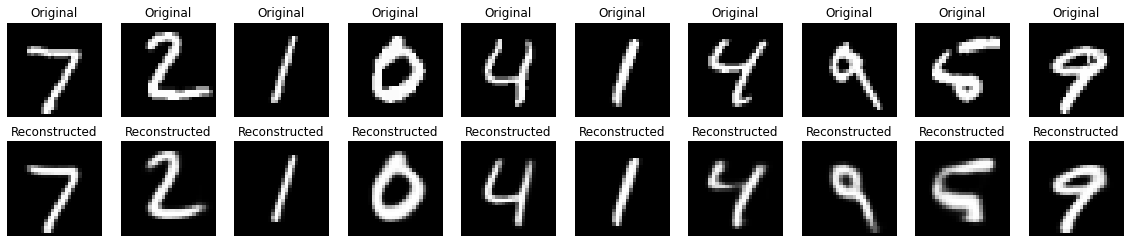

In [43]:
# Select a few images to display
n_images = 10
plt.figure(figsize=(20, 4))

for i in range(n_images):
    # Display original images
    ax = plt.subplot(2, n_images, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Display reconstructed images
    ax = plt.subplot(2, n_images, i + 1 + n_images)
    print(reconstructed_images[i].shape)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()


(10, 4, 4, 128)


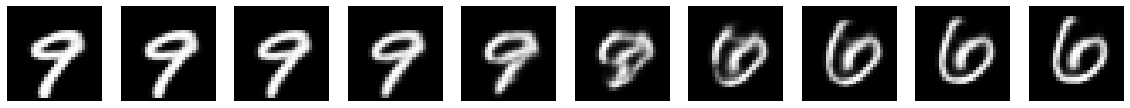

In [144]:
# Assuming latent_space is the latent representation of the test set
#print(y_test)
# index 0 is number 7
# index 1 is number 2
# index 2 is number 1
# index 3 is number 0
# index 4 is number 4
# index 5 is number 1
# index 6 is number 4
# index 7 is number 9
# index 8 is number 5
# index 9 is number 9
# index 11 is number 6
# index 15 is number 5
# index 19 is number 4
# index 30 is number 3
# index 84 is number 8

latent_vector_1 = latent_space[9]  # First image's latent vector
latent_vector_2 = latent_space[11]  # Second image's latent vector
#print(latent_vector_1.shape)

def interpolate_vectors(v1, v2, num_steps=10):
    return np.array([v1 + (v2 - v1) * t for t in np.linspace(0, 1, num_steps)])

# Get the interpolated latent vectors
interpolated_vectors = interpolate_vectors(latent_vector_1, latent_vector_2)
print(interpolated_vectors.shape)

# Decode the vectors to get images
decoded_images = decoder.predict(interpolated_vectors)

# Visualize the interpolated images
n_interpolations = len(interpolated_vectors)
plt.figure(figsize=(20, 4))

for i in range(n_interpolations):
    ax = plt.subplot(1, n_interpolations, i + 1)
    plt.imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()
